In [25]:
#!pip install -U featuretools
#!python -m pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import matplotlib.pyplot as plt


from woodwork.logical_types import Categorical, PostalCode


# Data Set
Source: https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-tutorial

Tables:
* clients: information about clients at a credit union
* loans: previous loans taken out by the clients
* payments: payments made/missed on the previous loans


Objective:
* Will Customer make or miss next payment

In [49]:
# Load Data
# Data set from kaggle ()
clients = pd.read_csv('./data/clients.csv', parse_dates = ['joined'])
clients['joined'] = pd.to_datetime(clients['joined']).dt.date


In [50]:
loans = pd.read_csv('./data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
loans['loan_start'] = pd.to_datetime(loans['loan_start']).dt.date
loans['loan_end'] = pd.to_datetime(loans['loan_end']).dt.date


In [51]:
payments = pd.read_csv('./data/payments.csv', parse_dates = ['payment_date'])
payments['payment_date'] = pd.to_datetime(payments['payment_date']).dt.date

## add a unique identifier to each row

In [52]:
# Sample data
# Specify the customer and loans of interest
customer_id = 26326
loans_of_interest = [11251,11988]

# Filter data for the specified customer and loans
clients_subset = clients[clients['client_id'] == 26326]
loans_subset = loans[(loans['loan_id'].isin(loans_of_interest))].sort_values(by = 'loan_start')
payments_subset = payments[payments['loan_id'].isin(loans_of_interest)]


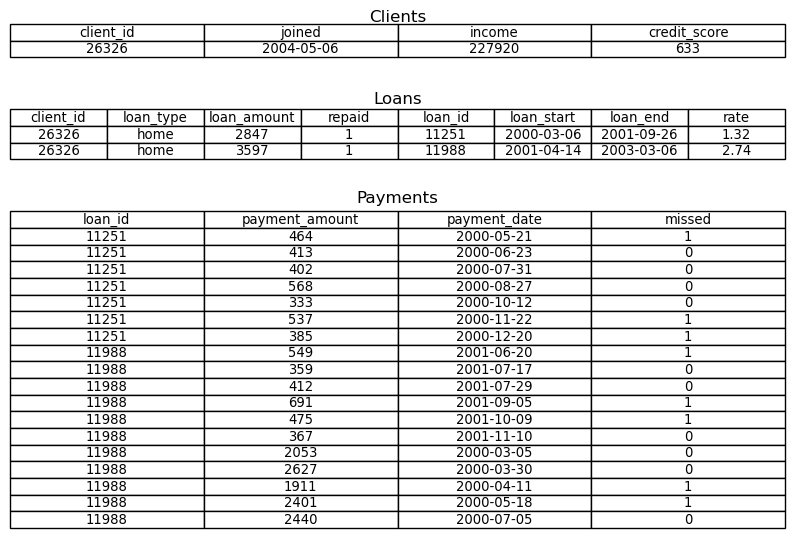

In [86]:
import matplotlib.pyplot as plt

# Assuming you have imported necessary libraries and defined dataframes (clients_subset, loans_subset, payments_subset)

# Visualize the data tables
fig, axs = plt.subplots(3, 1, figsize=(10, 2))

# Set the font size to 10x
font_size = 9.5

axs[0].axis('off')
table0 = axs[0].table(cellText=clients_subset.values, colLabels=clients_subset.columns, cellLoc='center', loc='top')
table0.auto_set_font_size(False)
table0.set_fontsize(font_size)
axs[0].set_title('Clients', y=1.6)

axs[1].axis('off')
table1 = axs[1].table(cellText=loans_subset.values, colLabels=loans_subset.columns, cellLoc='center', loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(font_size)
axs[1].set_title('Loans')

axs[2].axis('off')
table2 = axs[2].table(cellText=payments_subset.values, colLabels=payments_subset.columns, cellLoc='center', loc='bottom')
table2.auto_set_font_size(False)
table2.set_fontsize(font_size)
axs[2].set_title('Payments', y=0.0)

plt.show()




## Data Representation with EntitySets
An EntitySet is a collection of dataframes and the relationships between them. They are useful for preparing raw, structured datasets for feature engineering. While many functions in Featuretools take dataframes and relationships as separate arguments, it is recommended to create an EntitySet, so you can more easily manipulate your data as needed.



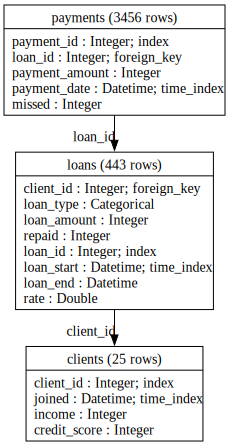

In [87]:
es = ft.EntitySet(id = 'clients')

## Entities Dataframe
es = es.add_dataframe(
    dataframe_name="clients",
    dataframe=clients,
    index="client_id",
    time_index="joined")

es = es.add_dataframe(
    dataframe_name="loans",
    dataframe=loans,
    index="loan_id",
    time_index="loan_start")

es = es.add_dataframe(
    dataframe_name="payments",
    dataframe=payments,
    index="payment_id",
    time_index="payment_date")

## Adding Relationships in dataframes

# Relationship between clients and previous loans
ed = es.add_relationship('clients', 'client_id', 'loans', 'client_id')

# Relationship between previous loans and previous payments
es = es.add_relationship('loans', 'loan_id', 'payments', 'loan_id')
es.plot()


# Feature primitives
Feature primitives are the building blocks of Featuretools. They define individual computations that can be applied to raw datasets to create new features. Because a primitive only constrains the input and output data types, they can be applied across datasets and can stack to create new calculations.

Feature primitives fall into two categories:

1. Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
2. Transformation: an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

In [34]:
primitives = ft.list_primitives()
# Set the maximum number of rows and columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [33]:
# Aggregation primitives
display(HTML('<div style="max-height:400px; overflow-y:scroll;">' + primitives[primitives['type'] == 'aggregation'].to_html() + '</div>'))


,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,n_unique_days,aggregation,False,False,Determines the number of unique days.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
1,num_peaks,aggregation,False,False,Determines the number of peaks in a list of numbers.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
2,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
3,max_consecutive_false,aggregation,False,False,Determines the maximum number of consecutive False values in the input,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
4,num_true,aggregation,True,False,Counts the number of `True` values.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
5,max_count,aggregation,False,False,Calculates the number of occurrences of the max value in a list,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
6,is_unique,aggregation,False,False,Determines whether or not a series of discrete is all unique.,<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = BooleanNullable)>
7,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
8,percent_unique,aggregation,False,False,Determines the percent of unique values.,<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
9,count_less_than,aggregation,False,False,Determines the number of values less than a controllable threshold.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>


In [35]:
# transform primitives
display(HTML('<div style="max-height:400px; overflow-y:scroll;">' + primitives[primitives['type'] == 'transform'].to_html() + '</div>'))

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,punctuation_count,transform,False,False,Determines number of punctuation characters in a string.,<ColumnSchema (Logical Type = NaturalLanguage)>,<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
66,less_than_scalar,transform,True,True,Determines if values are less than a given scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = BooleanNullable)>
67,month,transform,True,True,Determines the month value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,"<ColumnSchema (Logical Type = Ordinal: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) (Semantic Tags = ['category'])>"
68,is_month_start,transform,True,True,Determines the is_month_start attribute of a datetime column.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>
69,day_of_year,transform,True,True,Determines the ordinal day of the year from the given datetime,<ColumnSchema (Logical Type = Datetime)>,"<ColumnSchema (Logical Type = Ordinal: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366]) (Semantic Tags = ['category'])>"
70,not,transform,True,True,Negates a boolean value.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",<ColumnSchema (Logical Type = BooleanNullable)>
71,greater_than_scalar,transform,True,True,Determines if values are greater than a given scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = BooleanNullable)>
72,haversine,transform,False,False,Calculates the approximate haversine distance between two LatLong columns.,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Semantic Tags = ['numeric'])>
73,num_unique_separators,transform,False,False,Calculates the number of unique separators.,<ColumnSchema (Logical Type = NaturalLanguage)>,<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
74,greater_than_equal_to,transform,True,True,Determines if values in one list are greater than or equal to another list.,"<ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Logical Type = Ordinal: None)>, <ColumnSchema (Semantic Tags = ['numeric'])>",<ColumnSchema (Logical Type = BooleanNullable)>


In [42]:
es

Entityset: clients
  DataFrames:
    clients [Rows: 25, Columns: 4]
    loans [Rows: 443, Columns: 8]
    payments [Rows: 3456, Columns: 5]
  Relationships:
    loans.client_id -> clients.client_id
    payments.loan_id -> loans.loan_id

In [93]:
agg_primitives =  ["sum","min"]
trans_primitives = ["time_since_previous"]

# Deep feature synthesis 
feature_names = ft.dfs(entityset=es, target_dataframe_name='clients',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       features_only = True,
                       max_depth = 2)




Built 25 features


[<Feature: income>,
 <Feature: credit_score>,
 <Feature: MIN(loans.loan_amount)>,
 <Feature: MIN(loans.rate)>,
 <Feature: MIN(loans.repaid)>,
 <Feature: SUM(loans.loan_amount)>,
 <Feature: SUM(loans.rate)>,
 <Feature: SUM(loans.repaid)>,
 <Feature: MIN(payments.missed)>,
 <Feature: MIN(payments.payment_amount)>,
 <Feature: SUM(payments.missed)>,
 <Feature: SUM(payments.payment_amount)>,
 <Feature: TIME_SINCE_PREVIOUS(joined)>,
 <Feature: MIN(loans.SUM(payments.missed))>,
 <Feature: MIN(loans.SUM(payments.payment_amount))>,
 <Feature: MIN(loans.TIME_SINCE_PREVIOUS(loan_start))>,
 <Feature: SUM(loans.MIN(payments.missed))>,
 <Feature: SUM(loans.MIN(payments.payment_amount))>,
 <Feature: SUM(loans.TIME_SINCE_PREVIOUS(loan_start))>,
 <Feature: MIN(payments.loans.loan_amount)>,
 <Feature: MIN(payments.loans.rate)>,
 <Feature: MIN(payments.loans.repaid)>,
 <Feature: SUM(payments.loans.loan_amount)>,
 <Feature: SUM(payments.loans.rate)>,
 <Feature: SUM(payments.loans.repaid)>]

In [105]:
dtype(feature_names)

NameError: name 'dtype' is not defined

In [103]:
feature_names[feature_names == '<Feature: MIN(loans.TIME_SINCE_PREVIOUS(loan_start))>']

<Feature: income>

In [101]:
graph_feature = ft.graph_feature('<Feature: MIN(loans.TIME_SINCE_PREVIOUS(loan_start))>')
graph_feature


AttributeError: 'str' object has no attribute 'get_name'

In [66]:
feature_values = ft.calculate_feature_matrix(feature_names, entityset=es)
feature_values

,income,credit_score,SUM(loans.loan_amount),SUM(loans.rate),SUM(loans.repaid),SUM(payments.missed),SUM(payments.payment_amount),SUM(payments.loans.loan_amount),SUM(payments.loans.rate),SUM(payments.loans.repaid)
client_id,,,,,,,,,,
42320,229481,563,105931.0,36.86,9.0,62.0,122578.0,843367.0,302.84,70.0
39384,191204,617,149444.0,67.23,12.0,75.0,174270.0,1161741.0,499.12,84.0
26945,214516,806,106889.0,42.83,6.0,57.0,124261.0,771053.0,330.13,38.0
41472,152214,638,120173.0,63.70,8.0,51.0,118553.0,784731.0,435.36,56.0
46180,43851,562,154017.0,70.05,10.0,62.0,176796.0,1142666.0,578.43,74.0
...,...,...,...,...,...,...,...,...,...,...
35089,131176,771,138784.0,70.27,12.0,79.0,174065.0,1149727.0,530.09,101.0
46958,225709,644,121919.0,41.00,3.0,41.0,123870.0,859094.0,285.21,19.0
39505,153873,610,148481.0,63.81,9.0,72.0,175466.0,1155246.0,466.67,62.0


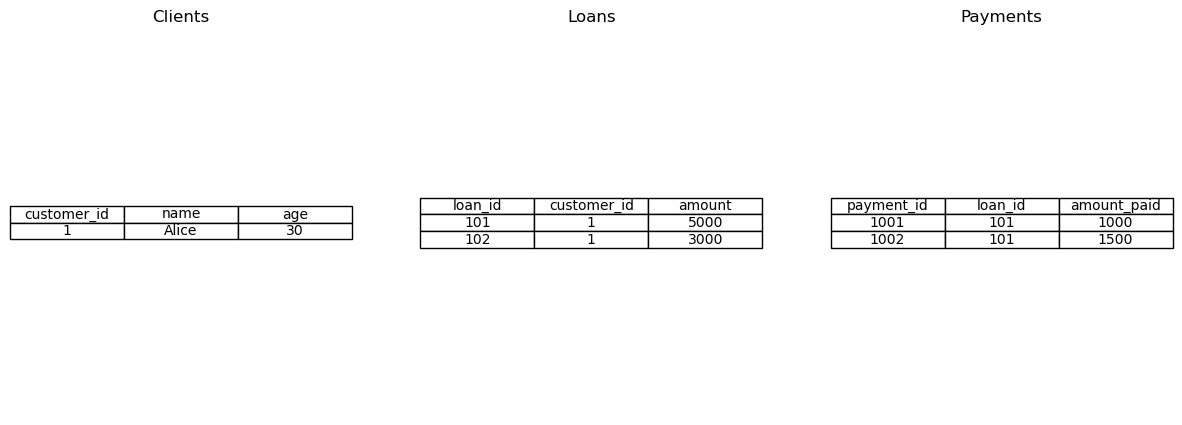

In [105]:
# Sample data
clients_data = {'customer_id': [1, 2],
                'name': ['Alice', 'Bob'],
                'age': [30, 25]}
clients = pd.DataFrame(clients_data)

loans_data = {'loan_id': [101, 102, 201, 202],
              'customer_id': [1, 1, 2, 2],
              'amount': [5000, 3000, 7000, 4000]}
loans = pd.DataFrame(loans_data)

payments_data = {'payment_id': [1001, 1002, 1003, 1004, 1005],
                 'loan_id': [101, 101, 201, 201, 202],
                 'amount_paid': [1000, 1500, 2000, 1000, 1200]}
payments = pd.DataFrame(payments_data)

# Specify the customer and loans of interest
customer_id = 1
loans_of_interest = [101, 102]

# Filter data for the specified customer and loans
clients_subset = clients[clients['customer_id'] == customer_id]
loans_subset = loans[loans['loan_id'].isin(loans_of_interest)]
payments_subset = payments[payments['loan_id'].isin(loans_of_interest)]

# Visualize the data tables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].axis('off')
axs[0].table(cellText=clients_subset.values, colLabels=clients_subset.columns, cellLoc='center', loc='center')
axs[0].set_title('Clients')

axs[1].axis('off')
axs[1].table(cellText=loans_subset.values, colLabels=loans_subset.columns, cellLoc='center', loc='center')
axs[1].set_title('Loans')

axs[2].axis('off')
axs[2].table(cellText=payments_subset.values, colLabels=payments_subset.columns, cellLoc='center', loc='center')
axs[2].set_title('Payments')

plt.show()


In [92]:
#Changing Target DataFrame
#DFS is powerful because we can create a feature matrix for any dataframe in our dataset. If we switch our target dataframe to “sessions”, we can synthesize features for each session instead of each customer. Now, we can use these features to predict the outcome of a session.

